In [2]:

import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd
# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

display(init_df.head())

,open,high,low,close,adjclose,volume,ticker
2020-08-20,76.998497,79.008499,76.723000,78.812500,78.812500,26382000,GOOGL
2020-08-21,78.589996,79.594002,78.115501,78.778503,78.778503,34838000,GOOGL
2020-08-24,79.623497,80.439003,78.751999,79.257500,79.257500,25638000,GOOGL
2020-08-25,79.004997,80.444000,78.893997,80.292503,80.292503,25150000,GOOGL
2020-08-26,80.315002,82.639503,80.049004,82.206497,82.206497,52188000,GOOGL


In [5]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'volume', 'ticker'], axis = 1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

display(init_df)

,close,date
2020-08-20,78.812500,2020-08-20
2020-08-21,78.778503,2020-08-21
2020-08-24,79.257500,2020-08-24
2020-08-25,80.292503,2020-08-25
2020-08-26,82.206497,2020-08-26
...,...,...
2023-08-22,129.080002,2023-08-22
2023-08-23,132.369995,2023-08-23
2023-08-24,129.779999,2023-08-24
2023-08-25,129.880005,2023-08-25


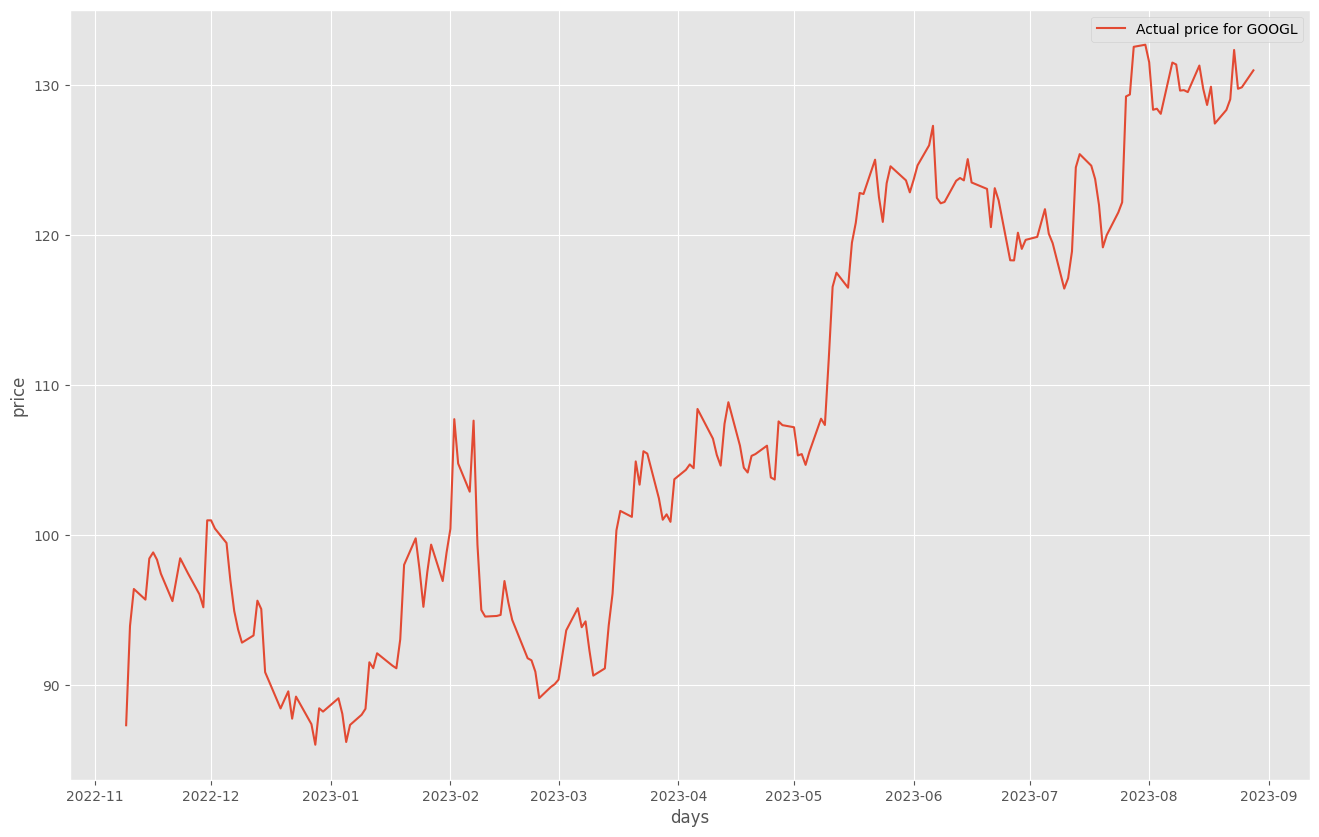

In [6]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()


In [7]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
display(init_df.tail())

,close,date
2023-08-22,0.738456,2023-08-22
2023-08-23,0.779908,2023-08-23
2023-08-24,0.747275,2023-08-24
2023-08-25,0.748535,2023-08-25
2023-08-28,0.762773,2023-08-28


In [8]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [9]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [10]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 2s 3ms/step - loss: 0.0190
Epoch 2/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3/80
95/95 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 4/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 5/80
95/95 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 6/80
95/95 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 7/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9/80
95/95 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 10/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 11/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 12/80
95/95 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 13/80
95/95 [==============================

In [11]:
if bool(predictions) == True and len(prediction) > 0:
    predictions_list = [str(d)+'$' for d in predictions]
    prediction_str = ','.join(predictions_list)
    message = f'{STOCK} prediction for upcoming 3 days ({prediction_str})'

    print(message)

GOOGL prediction for upcoming 3 days (133.3$,128.91$,130.92$)


24/24 [==============================] - 0s 2ms/step


,close,date,predicted_close
2020-08-20,78.812500,2020-08-20,85.869499
2020-08-21,78.778503,2020-08-21,81.475502
2020-08-24,79.257500,2020-08-24,79.060501
2020-08-25,80.292503,2020-08-25,76.180000
2020-08-26,82.206497,2020-08-26,77.361504
...,...,...,...
2023-08-22,129.080002,2023-08-22,129.230927
2023-08-23,132.369995,2023-08-23,131.283798
2023-08-24,129.779999,2023-08-24,129.779999
2023-08-25,129.880005,2023-08-25,129.880005


,close,date,predicted_close
2020-08-20 00:00:00,78.812500,2020-08-20 00:00:00,85.869499
2020-08-21 00:00:00,78.778503,2020-08-21 00:00:00,81.475502
2020-08-24 00:00:00,79.257500,2020-08-24 00:00:00,79.060501
2020-08-25 00:00:00,80.292503,2020-08-25 00:00:00,76.180000
2020-08-26 00:00:00,82.206497,2020-08-26 00:00:00,77.361504
...,...,...,...
2023-08-25 00:00:00,129.880005,2023-08-25 00:00:00,129.880005
2023-08-28 00:00:00,131.009995,2023-08-28 00:00:00,131.009995
2023-08-29,133.300000,2023-08-29,0.000000
2023-08-30,128.910000,2023-08-30,0.000000


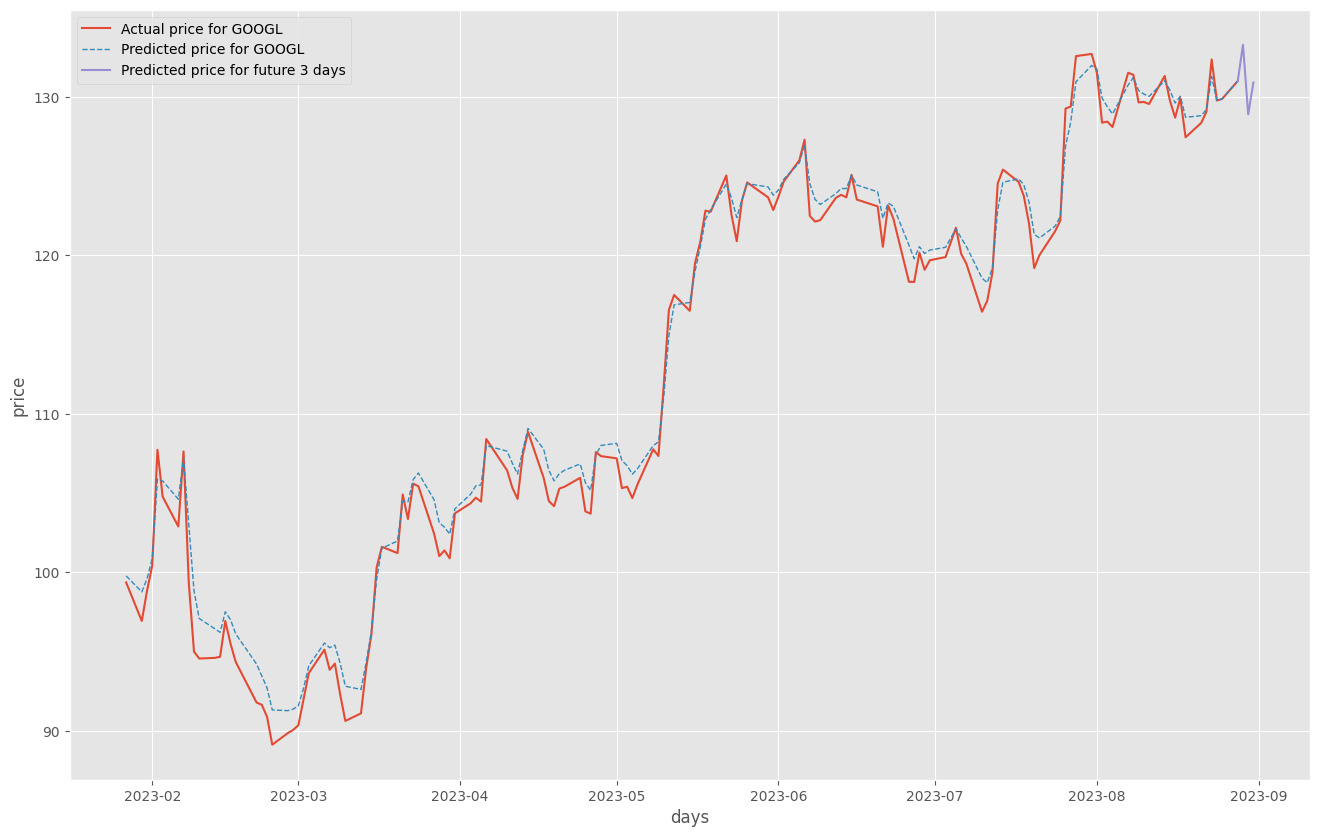

In [17]:
# Execute model for the whole history range
copy_df = init_df.copy()

y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed
copy_df[f'close'] = scaler.inverse_transform(np.expand_dims(copy_df['close'], axis=1))
display(copy_df)

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)


copy_df.loc[date_now] = [predictions[0], f'{date_now}',  0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0]



display(copy_df)
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()